# Análisis Exploratorio de Datos (EDA) - Dataset de Movimientos

Este notebook analiza el dataset `mediapipe_labels_dataset_enriched.csv` que contiene landmarks de MediaPipe Pose para diferentes actividades:
- Sentado
- Sentándose
- Poniéndose de pie
- De pie
- Caminando al frente
- Caminando atrás
- Girando

**Objetivos:**
1. Cargar y explorar el dataset
2. Extraer y visualizar los landmarks (esqueletos)
3. **Crear videos con esqueleto sobrepuesto sobre el video original**
4. Mostrar la actividad que se está realizando en cada momento
5. Análisis estadístico básico

## Características de los Videos Generados:
- Video original como fondo
- Esqueleto (landmarks) dibujado sobre el video
- Etiqueta de actividad mostrada en tiempo real
- Información de frame y timestamp
- Procesamiento de TODOS los videos completos

## 1. Importar Librerías

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Cargar Dataset

In [237]:
# Cargar el dataset
df = pd.read_csv('mediapipe_labels_dataset_enriched.csv')

print(f"Tamaño del dataset: {df.shape}")
print(f"   - Filas (frames): {df.shape[0]:,}")
print(f"   - Columnas: {df.shape[1]}")
print(f"\nVideos únicos: {df['video_id'].nunique()}")
print(f"Etiquetas únicas: {df['label'].nunique()}")
print(f"Dataset cargado exitosamente")

# Mostrar primeras filas
df.head()

Tamaño del dataset: (10380, 164)
   - Filas (frames): 10,380
   - Columnas: 164

Videos únicos: 18
Etiquetas únicas: 8
Dataset cargado exitosamente


,video_id,frame_opencv,frame_labelstudio,fps,timestamp_ms,width,height,x_0,y_0,z_0,...,speed_25,speed_26,speed_27,speed_28,knee_left_deg,knee_right_deg,elbow_left_deg,elbow_right_deg,segment_id,low_quality
0,1,0,0,29.960636,0.000000,848,480,0.385952,0.524163,-0.123012,...,0.000000,0.000000,0.000000,0.000000,110.671200,95.672214,115.582626,102.338598,1,False
1,1,1,0,29.960636,33.377129,848,480,0.389205,0.520536,-0.130491,...,0.240538,0.043676,0.215748,0.250958,95.061500,93.414203,109.048985,100.149391,1,False
2,1,2,1,29.960636,66.754258,848,480,0.390457,0.521935,-0.121937,...,0.093803,0.060829,0.027019,0.021920,92.522366,91.239800,105.084958,105.789282,2,False
3,1,3,2,29.960636,100.131387,848,480,0.390256,0.520495,-0.120354,...,0.015621,0.015882,0.030237,0.029610,93.778808,90.942712,106.103676,106.456378,2,False
4,1,4,3,29.960636,133.508516,848,480,0.390697,0.520327,-0.122076,...,0.036633,0.015316,0.037440,0.018879,94.202431,90.894555,107.642037,103.465511,2,False


## 3. Información General del Dataset

In [238]:
# Información básica
print("="*60)
print("INFORMACIÓN DEL DATASET")
print("="*60)

# Distribución de etiquetas
print("\nDistribución de etiquetas:")
label_counts = df['label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {label:25s}: {count:6,} frames ({percentage:5.2f}%)")

# Frames por video
print("\nFrames por video:")
video_stats = df.groupby('video_id').size()
print(f"   Total videos: {len(video_stats)}")
print(f"   Promedio: {video_stats.mean():.0f} frames")
print(f"   Mínimo: {video_stats.min()} frames")
print(f"   Máximo: {video_stats.max()} frames")

# Información sobre landmarks
print("\nInformación de Landmarks:")
print(f"   Total de landmarks por frame: 33")
print(f"   Coordenadas: x, y, z")
print(f"   Visibilidad promedio: {df['mean_visibility'].mean():.4f}")
print(f"   Landmarks visibles promedio: {df['num_visible_lms'].mean():.1f}/33")

INFORMACIÓN DEL DATASET

Distribución de etiquetas:
   Walk forward             :  2,275 frames (21.92%)
   Turn                     :  1,800 frames (17.34%)
   Walk backward            :  1,578 frames (15.20%)
   Get up                   :  1,468 frames (14.14%)
   Sitting                  :  1,274 frames (12.27%)
   Sit down                 :  1,018 frames ( 9.81%)
   Standing                 :    919 frames ( 8.85%)
   Unlabeled                :     48 frames ( 0.46%)

Frames por video:
   Total videos: 18
   Promedio: 577 frames
   Mínimo: 343 frames
   Máximo: 1029 frames

Información de Landmarks:
   Total de landmarks por frame: 33
   Coordenadas: x, y, z
   Visibilidad promedio: 0.9413
   Landmarks visibles promedio: 32.3/33


## 4. Visualizaciones Básicas

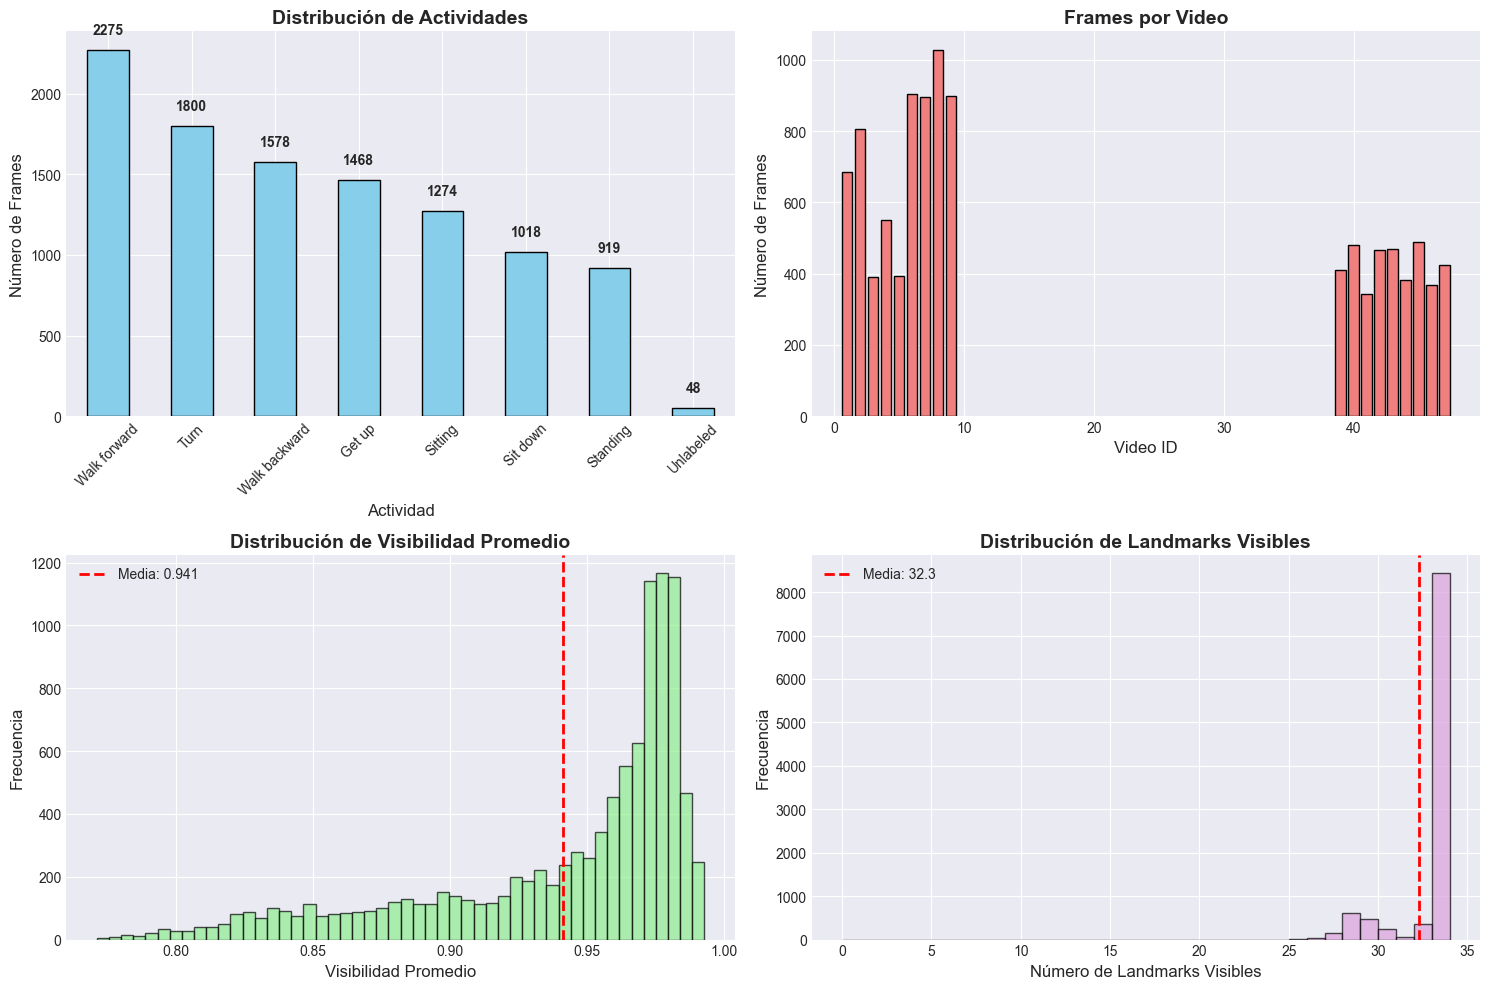

In [239]:
# Gráficos de distribución
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribución de etiquetas
ax1 = axes[0, 0]
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribución de Actividades', fontsize=14, fontweight='bold')
ax1.set_xlabel('Actividad', fontsize=12)
ax1.set_ylabel('Número de Frames', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 100, str(v), ha='center', fontweight='bold')

# 2. Frames por video
ax2 = axes[0, 1]
video_frames = df.groupby('video_id').size()
ax2.bar(video_frames.index, video_frames.values, color='lightcoral', edgecolor='black')
ax2.set_title('Frames por Video', fontsize=14, fontweight='bold')
ax2.set_xlabel('Video ID', fontsize=12)
ax2.set_ylabel('Número de Frames', fontsize=12)

# 3. Visibilidad promedio
ax3 = axes[1, 0]
ax3.hist(df['mean_visibility'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_title('Distribución de Visibilidad Promedio', fontsize=14, fontweight='bold')
ax3.set_xlabel('Visibilidad Promedio', fontsize=12)
ax3.set_ylabel('Frecuencia', fontsize=12)
ax3.axvline(df['mean_visibility'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["mean_visibility"].mean():.3f}')
ax3.legend()

# 4. Landmarks visibles
ax4 = axes[1, 1]
ax4.hist(df['num_visible_lms'], bins=range(0, 35), color='plum', edgecolor='black', alpha=0.7)
ax4.set_title('Distribución de Landmarks Visibles', fontsize=14, fontweight='bold')
ax4.set_xlabel('Número de Landmarks Visibles', fontsize=12)
ax4.set_ylabel('Frecuencia', fontsize=12)
ax4.axvline(df['num_visible_lms'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["num_visible_lms"].mean():.1f}')
ax4.legend()

plt.tight_layout()
plt.show()

## 5. Función para Extraer Landmarks del Dataset

In [240]:
def extract_landmarks_from_row(row):
    """
    Extrae los 33 landmarks de una fila del dataset.
    
    Returns:
        landmarks: np.array de forma (33, 4) con [x, y, z, visibility]
    """
    landmarks = []
    for i in range(33):
        x = row[f'x_{i}']
        y = row[f'y_{i}']
        z = row[f'z_{i}']
        v = row[f'v_{i}']
        landmarks.append([x, y, z, v])
    return np.array(landmarks)

# Probar la función con la primera fila
sample_landmarks = extract_landmarks_from_row(df.iloc[0])
print(f"Landmarks extraídos correctamente")
print(f"   Shape: {sample_landmarks.shape}")
print(f"   Primer landmark (nariz): x={sample_landmarks[0,0]:.4f}, y={sample_landmarks[0,1]:.4f}, z={sample_landmarks[0,2]:.4f}, v={sample_landmarks[0,3]:.4f}")

Landmarks extraídos correctamente
   Shape: (33, 4)
   Primer landmark (nariz): x=0.3860, y=0.5242, z=-0.1230, v=1.0000


## 6. Definir Conexiones del Esqueleto (MediaPipe Pose)

In [241]:
# Conexiones del esqueleto de MediaPipe Pose (33 landmarks)
# Basado en: https://google.github.io/mediapipe/solutions/pose.html

POSE_CONNECTIONS = [
    # Cara
    (0, 1), (1, 2), (2, 3), (3, 7),  # Lado derecho de la cara
    (0, 4), (4, 5), (5, 6), (6, 8),  # Lado izquierdo de la cara
    (9, 10),  # Boca
    
    # Torso
    (11, 12),  # Hombros
    (11, 23), (12, 24),  # Hombros a caderas
    (23, 24),  # Caderas
    
    # Brazo derecho
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
    
    # Brazo izquierdo
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
    
    # Pierna derecha
    (23, 25), (25, 27), (27, 29), (27, 31), (29, 31),
    
    # Pierna izquierda
    (24, 26), (26, 28), (28, 30), (28, 32), (30, 32),
]

print(f"Conexiones del esqueleto definidas: {len(POSE_CONNECTIONS)} líneas")

Conexiones del esqueleto definidas: 35 líneas


## 7. Función para Dibujar Esqueleto

In [242]:
def draw_skeleton(image, landmarks, connections, width=848, height=480):
    """
    Dibuja el esqueleto en una imagen.
    
    Args:
        image: Imagen donde dibujar (puede ser None para crear una negra)
        landmarks: Array de landmarks (33, 4) con [x, y, z, visibility]
        connections: Lista de tuplas con las conexiones
        width, height: Dimensiones de la imagen
    
    Returns:
        image: Imagen con el esqueleto dibujado
    """
    if image is None:
        image = np.zeros((height, width, 3), dtype=np.uint8)
    else:
        image = image.copy()
    
    # Dibujar conexiones
    for connection in connections:
        start_idx, end_idx = connection
        
        # Verificar visibilidad
        if landmarks[start_idx, 3] > 0.5 and landmarks[end_idx, 3] > 0.5:
            # Convertir coordenadas normalizadas a píxeles
            start_point = (
                int(landmarks[start_idx, 0] * width),
                int(landmarks[start_idx, 1] * height)
            )
            end_point = (
                int(landmarks[end_idx, 0] * width),
                int(landmarks[end_idx, 1] * height)
            )
            
            # Dibujar línea
            cv2.line(image, start_point, end_point, (0, 255, 0), 2)
    
    # Dibujar landmarks
    for i, landmark in enumerate(landmarks):
        if landmark[3] > 0.5:  # Solo si es visible
            x = int(landmark[0] * width)
            y = int(landmark[1] * height)
            
            # Color diferente para diferentes partes del cuerpo
            if i < 11:  # Cara
                color = (255, 0, 0)  # Azul
            elif i < 17:  # Brazos
                color = (0, 255, 255)  # Amarillo
            elif i < 25:  # Manos
                color = (255, 255, 0)  # Cian
            else:  # Piernas
                color = (0, 165, 255)  # Naranja
            
            cv2.circle(image, (x, y), 4, color, -1)
            cv2.circle(image, (x, y), 4, (255, 255, 255), 1)
    
    return image

print("Función de dibujo del esqueleto definida")

Función de dibujo del esqueleto definida


## 8. Visualizar Esqueletos de Muestra

### 8.1 Vista Previa: Esqueleto Sobre Frame Original

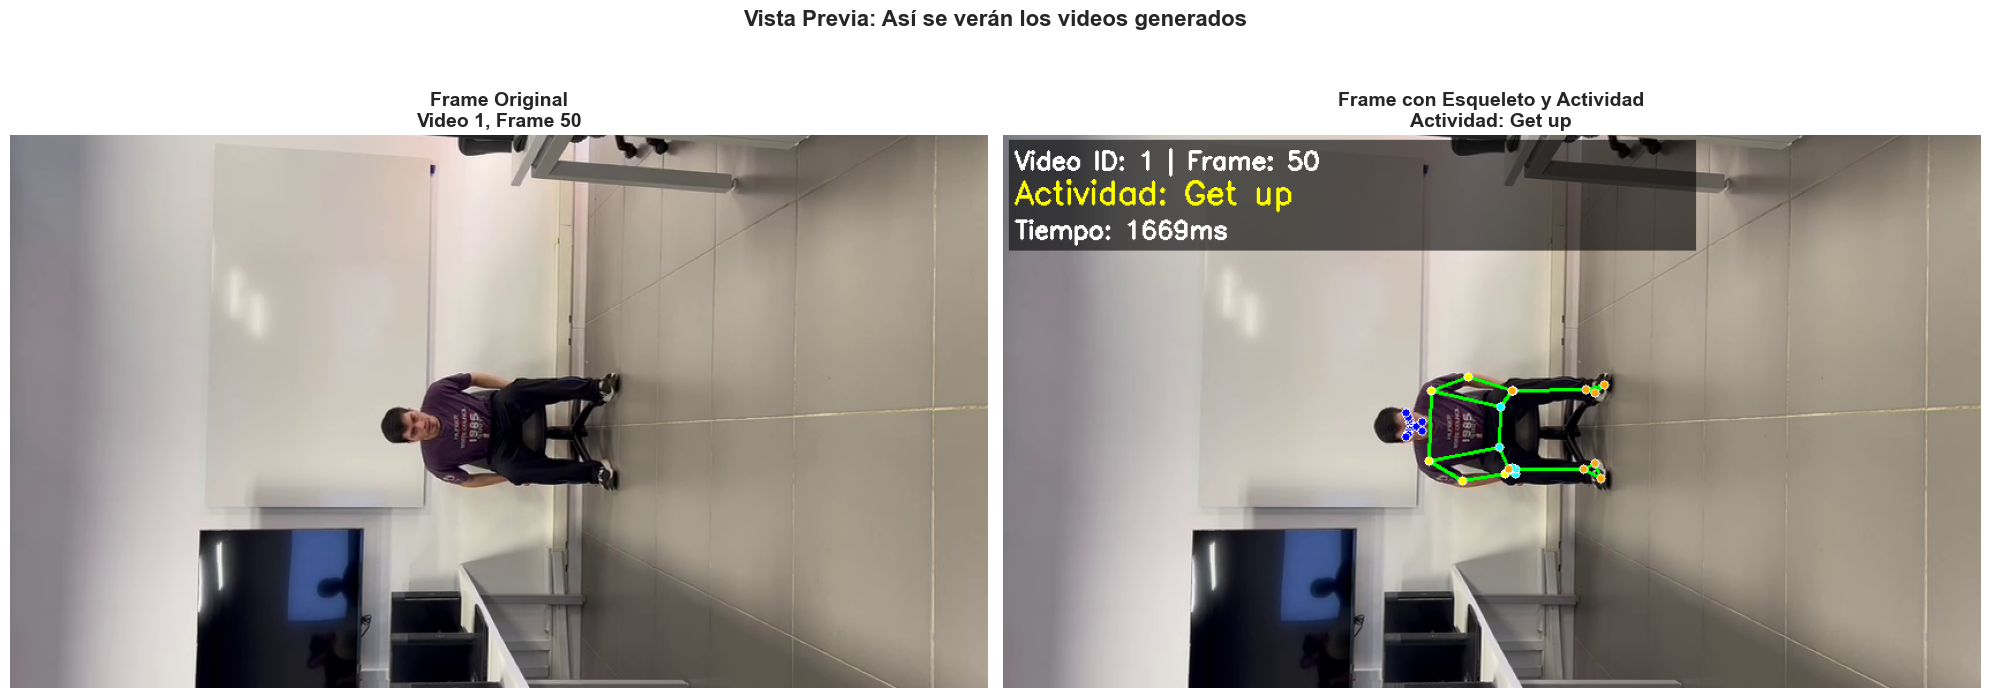

Vista previa generada
   Video: Video 12.mp4
   Actividad: Get up


In [243]:
# Vista previa de cómo se verá el esqueleto sobre el video original
VIDEOS_DIR = "videos APO/Videos APO"

# Seleccionar un video de ejemplo
example_video_id = df['video_id'].iloc[0]
example_row = df[df['video_id'] == example_video_id].iloc[50]  # Frame 50 como ejemplo

# Mapeo de video_id a archivo
video_mapping = {
    1: "Video 12.mp4", 2: "Video 18.mp4", 3: "Video 10.mp4", 4: "Video 11.mp4",
    5: "Video 13.mp4", 6: "Video 14.mp4", 7: "Video 15.mp4", 8: "Video 16.mp4",
    9: "Video 17.mp4", 39: "Video 1.mp4", 40: "Video 2.mp4", 41: "Video 3.mp4",
    42: "Video 4.mp4", 43: "Video 5.mp4", 44: "Video 6.mp4", 45: "Video 7.mp4",
    46: "Video 8.mp4", 47: "Video 9.mp4"
}

if example_video_id in video_mapping:
    video_path = os.path.join(VIDEOS_DIR, video_mapping[example_video_id])
    
    if os.path.exists(video_path):
        # Abrir video y obtener el frame específico
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(example_row['frame_opencv']))
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            # Extraer landmarks
            landmarks = extract_landmarks_from_row(example_row)
            
            # Crear comparación: Original vs Con Esqueleto
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))
            
            # Frame original
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[0].imshow(frame_rgb)
            axes[0].set_title(f'Frame Original\nVideo {example_video_id}, Frame {example_row["frame_opencv"]}', 
                            fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Frame con esqueleto
            frame_with_skeleton = draw_skeleton(frame.copy(), landmarks, POSE_CONNECTIONS, 
                                               int(example_row['width']), int(example_row['height']))
            
            # Agregar texto de actividad
            label = example_row['label']
            overlay = frame_with_skeleton.copy()
            cv2.rectangle(overlay, (5, 5), (600, 100), (0, 0, 0), -1)
            frame_with_skeleton = cv2.addWeighted(overlay, 0.6, frame_with_skeleton, 0.4, 0)
            
            cv2.putText(frame_with_skeleton, f'Video ID: {example_video_id} | Frame: {int(example_row["frame_opencv"])}', 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame_with_skeleton, f'Actividad: {label}', 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
            cv2.putText(frame_with_skeleton, f'Tiempo: {example_row["timestamp_ms"]:.0f}ms', 
                       (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            frame_skeleton_rgb = cv2.cvtColor(frame_with_skeleton, cv2.COLOR_BGR2RGB)
            axes[1].imshow(frame_skeleton_rgb)
            axes[1].set_title(f'Frame con Esqueleto y Actividad\nActividad: {label}', 
                            fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            plt.suptitle('Vista Previa: Así se verán los videos generados', 
                        fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout()
            plt.show()
            
            print(f"Vista previa generada")
            print(f"   Video: {video_mapping[example_video_id]}")
            print(f"   Actividad: {label}")
        else:
            print("No se pudo leer el frame del video")
    else:
        print(f"No se encontró el video: {video_path}")
else:
    print(f"Video ID {example_video_id} no está en el mapeo")

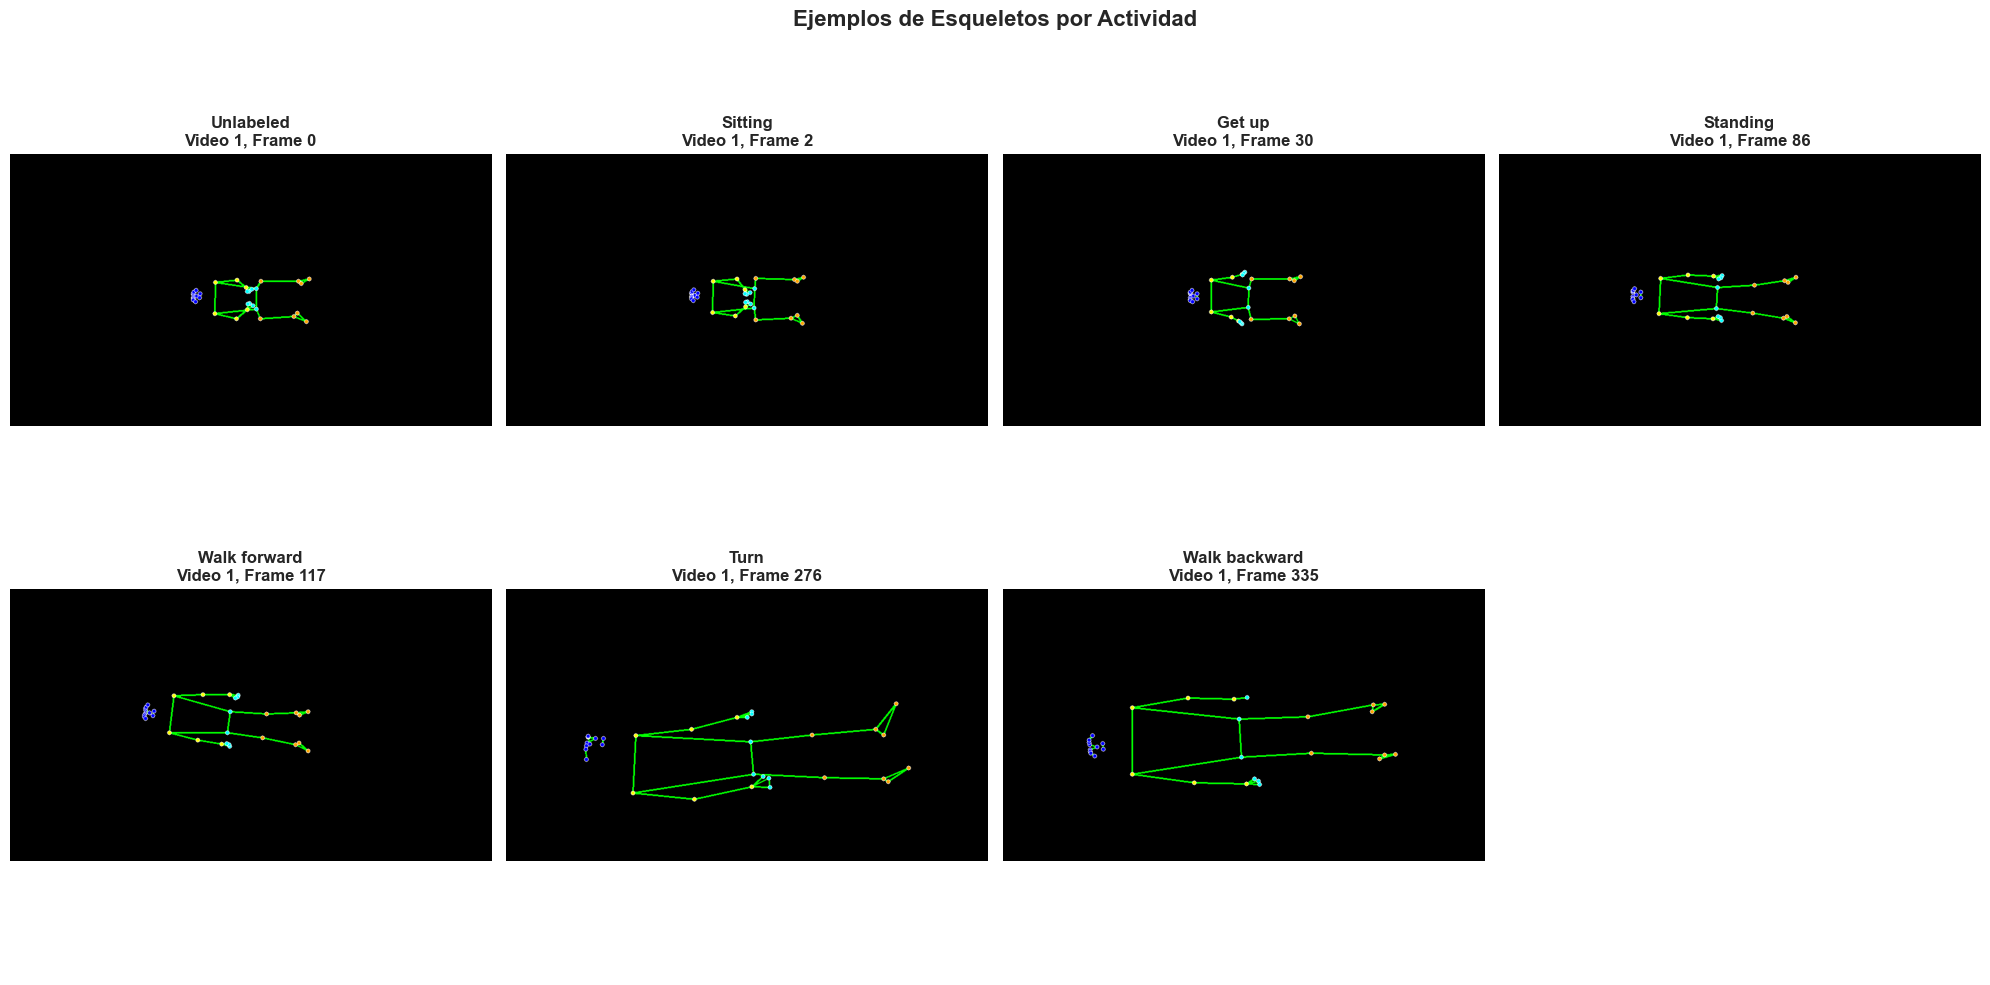

Visualización de 7 actividades completada


In [244]:
# Visualizar esqueletos de diferentes actividades
activities = df['label'].unique()[:7]  # Primeras 7 actividades únicas

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, activity in enumerate(activities):
    # Obtener una muestra de esa actividad
    sample = df[df['label'] == activity].iloc[0]
    landmarks = extract_landmarks_from_row(sample)
    
    # Dibujar esqueleto
    skeleton_img = draw_skeleton(None, landmarks, POSE_CONNECTIONS)
    
    # Convertir BGR a RGB para matplotlib
    skeleton_img_rgb = cv2.cvtColor(skeleton_img, cv2.COLOR_BGR2RGB)
    
    # Mostrar
    axes[idx].imshow(skeleton_img_rgb)
    axes[idx].set_title(f'{activity}\nVideo {sample["video_id"]}, Frame {sample["frame_opencv"]}', 
                       fontsize=12, fontweight='bold')
    axes[idx].axis('off')

# Ocultar ejes extras
for idx in range(len(activities), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Ejemplos de Esqueletos por Actividad', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"Visualización de {len(activities)} actividades completada")

## 9. Crear Videos de Verificación de Esqueletos

In [245]:
def create_skeleton_video(df, video_id, output_path, original_video_path, fps=30, max_frames=None):
    """
    Crea un video mostrando el esqueleto SOBREPUESTO en el video original.
    
    Args:
        df: DataFrame con los datos
        video_id: ID del video a procesar
        output_path: Ruta donde guardar el video
        original_video_path: Ruta del video original
        fps: Frames por segundo del video de salida
        max_frames: Número máximo de frames a procesar (None para todos)
    """
    # Filtrar datos del video
    video_data = df[df['video_id'] == video_id].sort_values('frame_opencv')
    
    if max_frames is not None:
        video_data = video_data.head(max_frames)
    
    if len(video_data) == 0:
        print(f"No hay datos para el video {video_id}")
        return
    
    # Abrir el video original
    cap = cv2.VideoCapture(original_video_path)
    if not cap.isOpened():
        print(f"No se pudo abrir el video: {original_video_path}")
        return
    
    # Obtener dimensiones
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Configurar el writer de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, original_fps, (width, height))
    
    print(f"Creando video para Video ID {video_id}...")
    print(f"   Video original: {original_video_path}")
    print(f"   Frames totales en video: {total_frames}")
    print(f"   Frames con datos: {len(video_data)}")
    print(f"   Dimensiones: {width}x{height}")
    print(f"   FPS: {original_fps:.2f}")
    print(f"   Output: {output_path}")
    
    # Crear un diccionario para búsqueda rápida de landmarks por frame
    frame_data_dict = {}
    for idx, row in video_data.iterrows():
        frame_num = int(row['frame_opencv'])
        frame_data_dict[frame_num] = row
    
    frame_idx = 0
    pbar = tqdm(total=len(video_data), desc="Procesando frames")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Si tenemos datos para este frame, dibujar el esqueleto
        if frame_idx in frame_data_dict:
            row = frame_data_dict[frame_idx]
            
            # Extraer landmarks
            landmarks = extract_landmarks_from_row(row)
            
            # Dibujar esqueleto sobre el frame original
            frame = draw_skeleton(frame, landmarks, POSE_CONNECTIONS, width, height)
            
            # Agregar información de texto
            label = row['label']
            timestamp = row['timestamp_ms']
            
            # Fondo semi-transparente para el texto
            overlay = frame.copy()
            cv2.rectangle(overlay, (5, 5), (600, 100), (0, 0, 0), -1)
            frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
            
            # Texto en el frame
            cv2.putText(frame, f'Video ID: {video_id} | Frame: {frame_idx}', 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, f'Actividad: {label}', 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
            cv2.putText(frame, f'Tiempo: {timestamp:.0f}ms', 
                       (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            pbar.update(1)
        
        # Escribir frame
        out.write(frame)
        frame_idx += 1
        
        if max_frames and frame_idx >= max_frames:
            break
    
    cap.release()
    out.release()
    pbar.close()
    print(f"Video creado exitosamente: {output_path}\n")

# Crear directorio para videos
os.makedirs('skeleton_videos', exist_ok=True)
print("Directorio 'skeleton_videos' creado/verificado")

Directorio 'skeleton_videos' creado/verificado


## 10. Generar Videos con Esqueletos Sobrepuestos (TODOS)

### 9.1 Verificar Videos Originales Disponibles

In [246]:
# Verificar qué videos originales están disponibles
VIDEOS_DIR = "videos APO/Videos APO"

print("="*60)
print("VERIFICANDO VIDEOS ORIGINALES")
print("="*60)

if os.path.exists(VIDEOS_DIR):
    available_videos = os.listdir(VIDEOS_DIR)
    available_videos = [v for v in available_videos if v.endswith('.mp4')]
    
    print(f"\nDirectorio: {VIDEOS_DIR}")
    print(f"Videos disponibles: {len(available_videos)}\n")
    
    for video in sorted(available_videos):
        video_path = os.path.join(VIDEOS_DIR, video)
        size_mb = os.path.getsize(video_path) / (1024 * 1024)
        print(f"   {video:20s} ({size_mb:.2f} MB)")
    
    # Obtener video IDs del dataset
    dataset_video_ids = sorted(df['video_id'].unique())
    print(f"\nVideos en el dataset: {len(dataset_video_ids)}")
    print(f"   IDs: {dataset_video_ids}")
    
else:
    print(f"No se encontró el directorio: {VIDEOS_DIR}")
    print("   Por favor, verifica la ruta de los videos originales")

print("="*60)

VERIFICANDO VIDEOS ORIGINALES

Directorio: videos APO/Videos APO
Videos disponibles: 18

   Video 1.mp4          (2.06 MB)
   Video 10.mp4         (1.90 MB)
   Video 11.mp4         (2.74 MB)
   Video 12.mp4         (3.36 MB)
   Video 13.mp4         (1.90 MB)
   Video 14.mp4         (2.23 MB)
   Video 15.mp4         (2.15 MB)
   Video 16.mp4         (2.53 MB)
   Video 17.mp4         (2.20 MB)
   Video 18.mp4         (1.98 MB)
   Video 2.mp4          (2.31 MB)
   Video 3.mp4          (1.69 MB)
   Video 4.mp4          (2.25 MB)
   Video 5.mp4          (2.32 MB)
   Video 6.mp4          (1.91 MB)
   Video 7.mp4          (2.38 MB)
   Video 8.mp4          (1.81 MB)
   Video 9.mp4          (2.06 MB)

Videos en el dataset: 18
   IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47)]


In [247]:
# Generar videos con esqueletos sobrepuestos para TODOS los videos
# Se procesa el video completo

print("="*60)
print("GENERANDO VIDEOS CON ESQUELETOS SOBREPUESTOS")
print("="*60)
print("Esto puede tomar bastante tiempo...\n")

# Ruta a los videos originales
VIDEOS_DIR = "videos APO/Videos APO"

# Mapeo de video_id a nombre de archivo
video_mapping = {
    1: "Video 12.mp4",
    2: "Video 18.mp4",
    3: "Video 10.mp4",
    4: "Video 11.mp4",
    5: "Video 13.mp4",
    6: "Video 14.mp4",
    7: "Video 15.mp4",
    8: "Video 16.mp4",
    9: "Video 17.mp4",
    39: "Video 1.mp4",
    40: "Video 2.mp4",
    41: "Video 3.mp4",
    42: "Video 4.mp4",
    43: "Video 5.mp4",
    44: "Video 6.mp4",
    45: "Video 7.mp4",
    46: "Video 8.mp4",
    47: "Video 9.mp4"
}

# Obtener TODOS los video IDs únicos del dataset
all_video_ids = sorted(df['video_id'].unique())

print(f"Total de videos a procesar: {len(all_video_ids)}")
print(f"Videos: {all_video_ids}\n")

successfully_created = 0
failed_videos = []

for idx, video_id in enumerate(all_video_ids, 1):
    print(f"\n[{idx}/{len(all_video_ids)}] Procesando Video ID {video_id}...")
    
    # Obtener nombre del archivo original
    if video_id in video_mapping:
        video_filename = video_mapping[video_id]
        original_video_path = os.path.join(VIDEOS_DIR, video_filename)
        
        # Verificar si existe el archivo
        if os.path.exists(original_video_path):
            output_file = f'skeleton_videos/video_{video_id}_with_skeleton.mp4'
            
            try:
                create_skeleton_video(df, video_id, output_file, original_video_path, max_frames=None)
                successfully_created += 1
            except Exception as e:
                print(f"Error procesando video {video_id}: {str(e)}")
                failed_videos.append(video_id)
        else:
            print(f"No se encontró el archivo: {original_video_path}")
            failed_videos.append(video_id)
    else:
        print(f"Video ID {video_id} no está en el mapeo")
        failed_videos.append(video_id)

print("\n" + "="*60)
print("PROCESAMIENTO COMPLETADO")
print("="*60)
print(f"Los videos están en la carpeta: skeleton_videos/")
print(f"Videos generados exitosamente: {successfully_created}/{len(all_video_ids)}")
if failed_videos:
    print(f"Videos que fallaron: {failed_videos}")
else:
    print("Todos los videos se generaron correctamente!")

GENERANDO VIDEOS CON ESQUELETOS SOBREPUESTOS
Esto puede tomar bastante tiempo...

Total de videos a procesar: 18
Videos: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47)]


[1/18] Procesando Video ID 1...
Creando video para Video ID 1...
   Video original: videos APO/Videos APO\Video 12.mp4
   Frames totales en video: 685
   Frames con datos: 685
   Dimensiones: 848x480
   FPS: 29.96
   Output: skeleton_videos/video_1_with_skeleton.mp4


Procesando frames: 100%|██████████| 685/685 [00:03<00:00, 204.97it/s]



Video creado exitosamente: skeleton_videos/video_1_with_skeleton.mp4


[2/18] Procesando Video ID 2...
Creando video para Video ID 2...
   Video original: videos APO/Videos APO\Video 18.mp4
   Frames totales en video: 805
   Frames con datos: 805
   Dimensiones: 464x832
   FPS: 59.94
   Output: skeleton_videos/video_2_with_skeleton.mp4


Procesando frames: 100%|██████████| 805/805 [00:03<00:00, 218.21it/s]



Video creado exitosamente: skeleton_videos/video_2_with_skeleton.mp4


[3/18] Procesando Video ID 3...
Creando video para Video ID 3...
   Video original: videos APO/Videos APO\Video 10.mp4
   Frames totales en video: 391
   Frames con datos: 390
   Dimensiones: 848x480
   FPS: 29.92
   Output: skeleton_videos/video_3_with_skeleton.mp4


Procesando frames: 100%|██████████| 390/390 [00:02<00:00, 156.41it/s]



Video creado exitosamente: skeleton_videos/video_3_with_skeleton.mp4


[4/18] Procesando Video ID 4...
Creando video para Video ID 4...
   Video original: videos APO/Videos APO\Video 11.mp4
   Frames totales en video: 551
   Frames con datos: 551
   Dimensiones: 848x480
   FPS: 29.90
   Output: skeleton_videos/video_4_with_skeleton.mp4


Procesando frames: 100%|██████████| 551/551 [00:02<00:00, 213.03it/s]



Video creado exitosamente: skeleton_videos/video_4_with_skeleton.mp4


[5/18] Procesando Video ID 5...
Creando video para Video ID 5...
   Video original: videos APO/Videos APO\Video 13.mp4
   Frames totales en video: 393
   Frames con datos: 393
   Dimensiones: 848x480
   FPS: 29.98
   Output: skeleton_videos/video_5_with_skeleton.mp4


Procesando frames: 100%|██████████| 393/393 [00:01<00:00, 210.64it/s]



Video creado exitosamente: skeleton_videos/video_5_with_skeleton.mp4


[6/18] Procesando Video ID 6...
Creando video para Video ID 6...
   Video original: videos APO/Videos APO\Video 14.mp4
   Frames totales en video: 905
   Frames con datos: 904
   Dimensiones: 464x832
   FPS: 59.94
   Output: skeleton_videos/video_6_with_skeleton.mp4


Procesando frames: 100%|██████████| 904/904 [00:03<00:00, 228.91it/s]



Video creado exitosamente: skeleton_videos/video_6_with_skeleton.mp4


[7/18] Procesando Video ID 7...
Creando video para Video ID 7...
   Video original: videos APO/Videos APO\Video 15.mp4
   Frames totales en video: 896
   Frames con datos: 896
   Dimensiones: 464x832
   FPS: 59.94
   Output: skeleton_videos/video_7_with_skeleton.mp4


Procesando frames: 100%|██████████| 896/896 [00:03<00:00, 234.79it/s]



Video creado exitosamente: skeleton_videos/video_7_with_skeleton.mp4


[8/18] Procesando Video ID 8...
Creando video para Video ID 8...
   Video original: videos APO/Videos APO\Video 16.mp4
   Frames totales en video: 1029
   Frames con datos: 1029
   Dimensiones: 464x832
   FPS: 59.94
   Output: skeleton_videos/video_8_with_skeleton.mp4


Procesando frames: 100%|██████████| 1029/1029 [00:04<00:00, 226.59it/s]



Video creado exitosamente: skeleton_videos/video_8_with_skeleton.mp4


[9/18] Procesando Video ID 9...
Creando video para Video ID 9...
   Video original: videos APO/Videos APO\Video 17.mp4
   Frames totales en video: 900
   Frames con datos: 900
   Dimensiones: 464x832
   FPS: 59.94
   Output: skeleton_videos/video_9_with_skeleton.mp4


Procesando frames: 100%|██████████| 900/900 [00:03<00:00, 234.34it/s]



Video creado exitosamente: skeleton_videos/video_9_with_skeleton.mp4


[10/18] Procesando Video ID 39...
Creando video para Video ID 39...
   Video original: videos APO/Videos APO\Video 1.mp4
   Frames totales en video: 409
   Frames con datos: 409
   Dimensiones: 848x480
   FPS: 29.93
   Output: skeleton_videos/video_39_with_skeleton.mp4


Procesando frames: 100%|██████████| 409/409 [00:01<00:00, 214.32it/s]



Video creado exitosamente: skeleton_videos/video_39_with_skeleton.mp4


[11/18] Procesando Video ID 40...
Creando video para Video ID 40...
   Video original: videos APO/Videos APO\Video 2.mp4
   Frames totales en video: 479
   Frames con datos: 479
   Dimensiones: 848x480
   FPS: 29.94
   Output: skeleton_videos/video_40_with_skeleton.mp4


Procesando frames: 100%|██████████| 479/479 [00:02<00:00, 213.63it/s]



Video creado exitosamente: skeleton_videos/video_40_with_skeleton.mp4


[12/18] Procesando Video ID 41...
Creando video para Video ID 41...
   Video original: videos APO/Videos APO\Video 3.mp4
   Frames totales en video: 343
   Frames con datos: 343
   Dimensiones: 848x480
   FPS: 29.91
   Output: skeleton_videos/video_41_with_skeleton.mp4


Procesando frames: 100%|██████████| 343/343 [00:01<00:00, 214.41it/s]



Video creado exitosamente: skeleton_videos/video_41_with_skeleton.mp4


[13/18] Procesando Video ID 42...
Creando video para Video ID 42...
   Video original: videos APO/Videos APO\Video 4.mp4
   Frames totales en video: 467
   Frames con datos: 467
   Dimensiones: 848x480
   FPS: 29.94
   Output: skeleton_videos/video_42_with_skeleton.mp4


Procesando frames: 100%|██████████| 467/467 [00:02<00:00, 214.33it/s]



Video creado exitosamente: skeleton_videos/video_42_with_skeleton.mp4


[14/18] Procesando Video ID 43...
Creando video para Video ID 43...
   Video original: videos APO/Videos APO\Video 5.mp4
   Frames totales en video: 468
   Frames con datos: 468
   Dimensiones: 848x480
   FPS: 29.94
   Output: skeleton_videos/video_43_with_skeleton.mp4


Procesando frames: 100%|██████████| 468/468 [00:02<00:00, 201.75it/s]



Video creado exitosamente: skeleton_videos/video_43_with_skeleton.mp4


[15/18] Procesando Video ID 44...
Creando video para Video ID 44...
   Video original: videos APO/Videos APO\Video 6.mp4
   Frames totales en video: 382
   Frames con datos: 382
   Dimensiones: 848x480
   FPS: 29.93
   Output: skeleton_videos/video_44_with_skeleton.mp4


Procesando frames: 100%|██████████| 382/382 [00:01<00:00, 195.97it/s]



Video creado exitosamente: skeleton_videos/video_44_with_skeleton.mp4


[16/18] Procesando Video ID 45...
Creando video para Video ID 45...
   Video original: videos APO/Videos APO\Video 7.mp4
   Frames totales en video: 488
   Frames con datos: 488
   Dimensiones: 848x480
   FPS: 29.94
   Output: skeleton_videos/video_45_with_skeleton.mp4


Procesando frames: 100%|██████████| 488/488 [00:02<00:00, 197.98it/s]


Video creado exitosamente: skeleton_videos/video_45_with_skeleton.mp4


[17/18] Procesando Video ID 46...
Creando video para Video ID 46...
   Video original: videos APO/Videos APO\Video 8.mp4
   Frames totales en video: 368
   Frames con datos: 368
   Dimensiones: 848x480
   FPS: 29.92
   Output: skeleton_videos/video_46_with_skeleton.mp4


Procesando frames: 100%|██████████| 368/368 [00:01<00:00, 194.88it/s]



Video creado exitosamente: skeleton_videos/video_46_with_skeleton.mp4


[18/18] Procesando Video ID 47...
Creando video para Video ID 47...
   Video original: videos APO/Videos APO\Video 9.mp4
   Frames totales en video: 423
   Frames con datos: 423
   Dimensiones: 848x480
   FPS: 29.93
   Output: skeleton_videos/video_47_with_skeleton.mp4


Procesando frames: 100%|██████████| 423/423 [00:02<00:00, 185.67it/s]

Video creado exitosamente: skeleton_videos/video_47_with_skeleton.mp4


PROCESAMIENTO COMPLETADO
Los videos están en la carpeta: skeleton_videos/
Videos generados exitosamente: 18/18
Todos los videos se generaron correctamente!


## 11. Análisis de Calidad de Landmarks

Verificar la calidad de los landmarks detectados

ANALISIS DE CALIDAD DE LANDMARKS

 Top 10 Landmarks MAS visibles:
 Landmark_ID      Nombre  Visibilidad_Promedio
          12  Hombro_Der              0.999901
          11  Hombro_Izq              0.999724
          24  Cadera_Der              0.999654
           0       Nariz              0.999633
          10    Boca_Der              0.999621
          23  Cadera_Izq              0.999584
           5     Ojo_Der              0.999480
           6 Ojo_Der_Ext              0.999474
           4 Ojo_Der_Int              0.999445
           9    Boca_Izq              0.999389

  Top 10 Landmarks MENOS visibles:
 Landmark_ID      Nombre  Visibilidad_Promedio
          16  Muñeca_Der              0.889198
          29   Talón_Izq              0.884391
          30   Talón_Der              0.869329
          15  Muñeca_Izq              0.865694
          18 Meñique_Der              0.849038
          20  Índice_Der              0.848937
          17 Meñique_Izq              0.830545
     

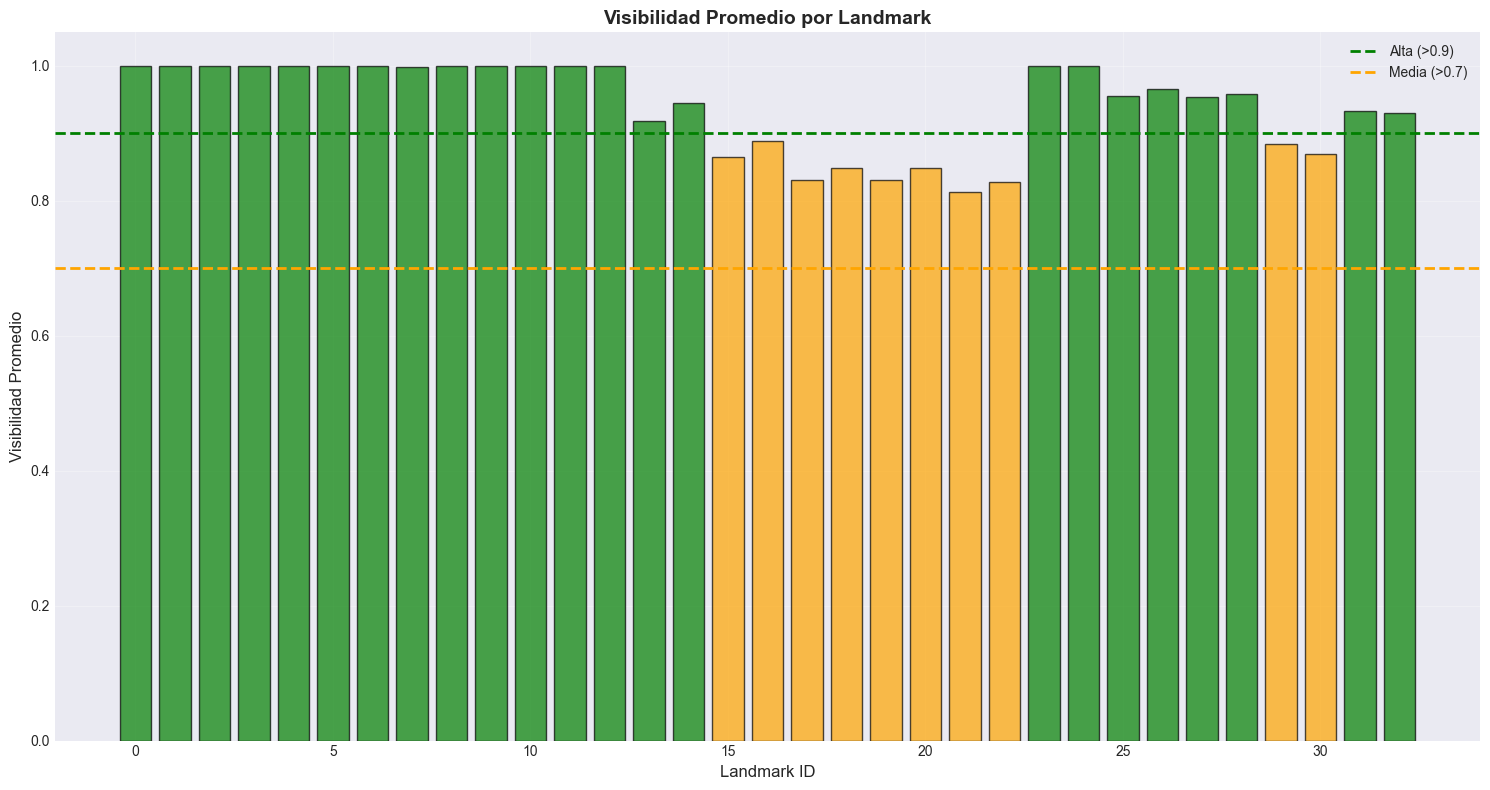

In [248]:
# Analizar la visibilidad de cada landmark
print("="*60)
print("ANALISIS DE CALIDAD DE LANDMARKS")
print("="*60)

# Calcular visibilidad promedio por landmark
landmark_visibility = []
for i in range(33):
    vis = df[f'v_{i}'].mean()
    landmark_visibility.append(vis)

# Nombres de los landmarks de MediaPipe
landmark_names = [
    "Nariz", "Ojo_Izq_Int", "Ojo_Izq", "Ojo_Izq_Ext", "Ojo_Der_Int", "Ojo_Der", "Ojo_Der_Ext",
    "Oreja_Izq", "Oreja_Der", "Boca_Izq", "Boca_Der",
    "Hombro_Izq", "Hombro_Der", "Codo_Izq", "Codo_Der", "Muñeca_Izq", "Muñeca_Der",
    "Meñique_Izq", "Meñique_Der", "Índice_Izq", "Índice_Der", "Pulgar_Izq", "Pulgar_Der",
    "Cadera_Izq", "Cadera_Der", "Rodilla_Izq", "Rodilla_Der", "Tobillo_Izq", "Tobillo_Der",
    "Talón_Izq", "Talón_Der", "Dedos_Izq", "Dedos_Der"
]

# Crear DataFrame de análisis
landmark_analysis = pd.DataFrame({
    'Landmark_ID': range(33),
    'Nombre': landmark_names,
    'Visibilidad_Promedio': landmark_visibility
})

# Ordenar por visibilidad
landmark_analysis_sorted = landmark_analysis.sort_values('Visibilidad_Promedio', ascending=False)

print("\n Top 10 Landmarks MAS visibles:")
print(landmark_analysis_sorted.head(10).to_string(index=False))

print("\n  Top 10 Landmarks MENOS visibles:")
print(landmark_analysis_sorted.tail(10).to_string(index=False))

# Gráfico de visibilidad
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['green' if v > 0.9 else 'orange' if v > 0.7 else 'red' for v in landmark_visibility]
ax.bar(range(33), landmark_visibility, color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('Landmark ID', fontsize=12)
ax.set_ylabel('Visibilidad Promedio', fontsize=12)
ax.set_title('Visibilidad Promedio por Landmark', fontsize=14, fontweight='bold')
ax.axhline(y=0.9, color='green', linestyle='--', linewidth=2, label='Alta (>0.9)')
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Media (>0.7)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## 12. Resumen y Conclusiones

In [249]:
print("="*70)
print("RESUMEN DEL ANÁLISIS")
print("="*70)

print("\nDATASET:")
print(f"   • Total de frames: {len(df):,}")
print(f"   • Total de videos: {df['video_id'].nunique()}")
print(f"   • Actividades únicas: {df['label'].nunique()}")
print(f"   • Dimensiones de video: {int(df.iloc[0]['width'])}x{int(df.iloc[0]['height'])}")

print("\nDISTRIBUCIÓN DE ACTIVIDADES:")
for label, count in df['label'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   • {label:25s}: {count:6,} frames ({percentage:5.2f}%)")

print("\nLANDMARKS:")
print(f"   • Total de landmarks por frame: 33")
print(f"   • Visibilidad promedio: {df['mean_visibility'].mean():.4f}")
print(f"   • Landmarks visibles promedio: {df['num_visible_lms'].mean():.1f}/33")
print(f"   • Conexiones del esqueleto: {len(POSE_CONNECTIONS)}")

print("\nCALIDAD DE DATOS:")
high_vis = sum(1 for v in landmark_visibility if v > 0.9)
medium_vis = sum(1 for v in landmark_visibility if 0.7 < v <= 0.9)
low_vis = sum(1 for v in landmark_visibility if v <= 0.7)
print(f"   • Landmarks con alta visibilidad (>0.9): {high_vis}/33")
print(f"   • Landmarks con visibilidad media (0.7-0.9): {medium_vis}/33")
print(f"   • Landmarks con baja visibilidad (<0.7): {low_vis}/33")

print("\nVIDEOS GENERADOS:")
print(f"   • Ubicación: skeleton_videos/")
print(f"   • Formato: MP4 con video original + esqueleto sobrepuesto")
print(f"   • Videos procesados: {successfully_created}/{len(all_video_ids)}")
print(f"   • Características:")
print(f"     - Video original como fondo")
print(f"     - Esqueleto dibujado sobre el video")
print(f"     - Información de actividad en pantalla")
print(f"     - Timestamp y número de frame")

print("\nPROXIMOS PASOS:")
print("   1. Revisar los videos generados en skeleton_videos/")
print("   2. Verificar que los esqueletos estén correctamente alineados")
print("   3. Verificar que las etiquetas correspondan a las acciones")
print("   4. Analizar patrones de movimiento por actividad")
print("   5. Preparar los datos para modelado de Machine Learning")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)

RESUMEN DEL ANÁLISIS

DATASET:
   • Total de frames: 10,380
   • Total de videos: 18
   • Actividades únicas: 8
   • Dimensiones de video: 848x480

DISTRIBUCIÓN DE ACTIVIDADES:
   • Walk forward             :  2,275 frames (21.92%)
   • Turn                     :  1,800 frames (17.34%)
   • Walk backward            :  1,578 frames (15.20%)
   • Get up                   :  1,468 frames (14.14%)
   • Sitting                  :  1,274 frames (12.27%)
   • Sit down                 :  1,018 frames ( 9.81%)
   • Standing                 :    919 frames ( 8.85%)
   • Unlabeled                :     48 frames ( 0.46%)

LANDMARKS:
   • Total de landmarks por frame: 33
   • Visibilidad promedio: 0.9413
   • Landmarks visibles promedio: 32.3/33
   • Conexiones del esqueleto: 35

CALIDAD DE DATOS:
   • Landmarks con alta visibilidad (>0.9): 23/33
   • Landmarks con visibilidad media (0.7-0.9): 10/33
   • Landmarks con baja visibilidad (<0.7): 0/33

VIDEOS GENERADOS:
   • Ubicación: skeleton_videos/

## 13. Instrucciones para Ver los Videos Generados

In [250]:
print("="*70)
print("COMO VER LOS VIDEOS GENERADOS")
print("="*70)

print("\nLos videos están en la carpeta: skeleton_videos/")
print("\nPuedes ver los videos de las siguientes formas:")
print("\n1)  Desde el Explorador de Windows:")
print("   - Abre la carpeta: AI_DetectionOfMovements/Entrega 1/skeleton_videos/")
print("   - Haz doble clic en cualquier video para reproducirlo")

print("\n2)  Desde la terminal:")
print("   - cd skeleton_videos")
print("   - start video_1_with_skeleton.mp4  # O el video que quieras ver")

print("\n3)  Reproducir directamente con Python:")
print("   - Ejecuta la celda de abajo para ver un video de ejemplo")

print("\nNombres de los archivos generados:")
for video_id in sorted(df['video_id'].unique()):
    filename = f"video_{video_id}_with_skeleton.mp4"
    if video_id in video_mapping:
        original = video_mapping[video_id]
        print(f"   • {filename:35s} <- {original}")

print("\nCada video muestra:")
print("   - Video original de la persona")
print("   - Esqueleto (landmarks) sobrepuesto en tiempo real")
print("   - Actividad actual mostrada en la parte superior")
print("   - Información de frame y timestamp")
print("   - Landmarks en diferentes colores por parte del cuerpo:")
print("      - Azul: Cara")
print("      - Amarillo: Brazos")
print("      - Cian: Manos")
print("      - Naranja: Piernas")

print("\n" + "="*70)

COMO VER LOS VIDEOS GENERADOS

Los videos están en la carpeta: skeleton_videos/

Puedes ver los videos de las siguientes formas:

1)  Desde el Explorador de Windows:
   - Abre la carpeta: AI_DetectionOfMovements/Entrega 1/skeleton_videos/
   - Haz doble clic en cualquier video para reproducirlo

2)  Desde la terminal:
   - cd skeleton_videos
   - start video_1_with_skeleton.mp4  # O el video que quieras ver

3)  Reproducir directamente con Python:
   - Ejecuta la celda de abajo para ver un video de ejemplo

Nombres de los archivos generados:
   • video_1_with_skeleton.mp4           <- Video 12.mp4
   • video_2_with_skeleton.mp4           <- Video 18.mp4
   • video_3_with_skeleton.mp4           <- Video 10.mp4
   • video_4_with_skeleton.mp4           <- Video 11.mp4
   • video_5_with_skeleton.mp4           <- Video 13.mp4
   • video_6_with_skeleton.mp4           <- Video 14.mp4
   • video_7_with_skeleton.mp4           <- Video 15.mp4
   • video_8_with_skeleton.mp4           <- Video 16.

### 13.1 Reproducir Video de Ejemplo con OpenCV

In [251]:
# Función opcional para reproducir un video con OpenCV
def play_video(video_path, window_name="Video con Esqueleto"):
    """
    Reproduce un video usando OpenCV.
    Presiona 'q' para salir, ESPACIO para pausar.
    """
    if not os.path.exists(video_path):
        print(f"No se encontró el video: {video_path}")
        return
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"No se pudo abrir el video: {video_path}")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    delay = int(1000 / fps) if fps > 0 else 30
    
    print(f"Reproduciendo: {video_path}")
    print(f"   Presiona 'q' para salir")
    print(f"   Presiona ESPACIO para pausar/reanudar")
    
    paused = False
    
    while True:
        if not paused:
            ret, frame = cap.read()
            if not ret:
                print("Video terminado")
                break
        
        cv2.imshow(window_name, frame)
        
        key = cv2.waitKey(delay) & 0xFF
        if key == ord('q'):
            print("Reproducción detenida por el usuario")
            break
        elif key == ord(' '):
            paused = not paused
            if paused:
                print("Pausado (presiona ESPACIO para continuar)")
            else:
                print("Reanudando...")
    
    cap.release()
    cv2.destroyAllWindows()

# Ejemplo: Descomentar para reproducir el primer video
# play_video('skeleton_videos/video_1_with_skeleton.mp4')

print("Función de reproducción definida")
print("Descomenta la última línea para reproducir un video de ejemplo")

Función de reproducción definida
Descomenta la última línea para reproducir un video de ejemplo
